# Full Function Study Notebook

This notebook performs a full analytical study of a real-valued function following the standard textbook methodology: domain determination, limits at boundaries, derivatives, critical points, monotonicity, convexity/concavity and inflection points, asymptotes, local and global extrema, range, and visualization. Results are displayed in MathJax (LaTeX) for clarity.

In [1]:
# Cell 1: Imports and helper functions
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sympy import S, latex
from IPython.display import display, Math, Markdown

sp.init_printing(use_unicode=True)

def global_extrema(f_sym, var, interval, samples=1000):
    """Sample a symbolic function on a given interval to estimate global min/max."""
    if not isinstance(interval, sp.Interval):
        raise ValueError('Interval must be a sympy Interval')
    a = interval.start
    b = interval.end
    def numify(u):
        if u is sp.S.NegativeInfinity:
            return -10.0
        if u is sp.S.Infinity:
            return 10.0
        return float(sp.N(u))
    left = numify(a)
    right = numify(b)
    if left >= right:
        pts = np.linspace(-10, 10, samples)
    else:
        eps = 1e-6
        if interval.left_open:
            left += eps
        if interval.right_open:
            right -= eps
        pts = np.linspace(left, right, samples)
    f_num = sp.lambdify(var, f_sym, 'numpy')
    with np.errstate(all='ignore'):
        vals = f_num(pts)
    finite_mask = np.isfinite(vals)
    if not np.any(finite_mask):
        return None, None
    filtered = vals[finite_mask]
    pts_filtered = pts[finite_mask]
    idx_min = np.argmin(filtered)
    idx_max = np.argmax(filtered)
    return (pts_filtered[idx_min], filtered[idx_min]), (pts_filtered[idx_max], filtered[idx_max])

def show_extrema_table(local_extrema, endpoint_values, f_sym, var, function_range):
    rows = []
    for cp, typ in local_extrema.items():
        try:
            val = sp.simplify(f_sym.subs(var, cp))
        except Exception:
            val = sp.Symbol('undefined')
        global_tag = ''
        if isinstance(function_range, sp.Interval):
            if val == function_range.start:
                global_tag = 'global min'
            elif val == function_range.end:
                global_tag = 'global max'
        rows.append((cp, val, typ, global_tag))
    for ep, val in endpoint_values.items():
        rows.append((ep, val, 'endpoint', ''))
    header = r"\begin{array}{c c c c}" + "\n" + r"x & f(x) & type & global \\ \hline" + "\n"
    body = ''
    for cp, val, typ, gt in rows:
        body += f"${{latex(cp)}}$ & ${{latex(val)}}$ & {typ} & {gt} \\\\ \n"
    # fix latex injection: manually format with latex()
    body = ''
    for cp, val, typ, gt in rows:
        body += f"${latex(cp)}$ & ${latex(val)}$ & {typ} & {gt} \\\\ \n"
    footer = r"\end{array}"
    table = header + body + footer
    display(Math(table))


In [2]:
# Cell 2: Define the function to study
x = sp.symbols('x', real=True)
# Edit this expression to analyze a different function:
expr = "x/(x**2 + 1)"
f = sp.sympify(expr, locals={'x': x})
f = sp.simplify(f)
display(Math(r"f(x) = " + latex(f)))

<IPython.core.display.Math object>

In [3]:
# Cell 3: Domain and boundary behavior
domain = sp.calculus.util.continuous_domain(f, x, S.Reals)
display(Math(r"\text{Domain: } " + latex(domain)))

intervals = list(domain.args) if isinstance(domain, sp.Union) else [domain]
limits = {}
endpoint_values = {}
for interval in intervals:
    if isinstance(interval, sp.Interval):
        left = interval.start
        right = interval.end
        if left is not sp.S.NegativeInfinity:
            if interval.left_open:
                limits[f'limit_right_at_{left}'] = sp.limit(f, x, left, dir='+')
            else:
                val = f.subs(x, left)
                endpoint_values[left] = sp.simplify(val)
        if right is not sp.S.Infinity:
            if interval.right_open:
                limits[f'limit_left_at_{right}'] = sp.limit(f, x, right, dir='-')
            else:
                val = f.subs(x, right)
                endpoint_values[right] = sp.simplify(val)

# Display limits at open endpoints
if limits:
    lines = []
    for name, val in limits.items():
        point = name.split("_at_")[-1]
        if name.startswith('limit_right'):
            lines.append(r"\lim_{x \to " + point + r"^+} f(x) = " + latex(val))
        elif name.startswith('limit_left'):
            lines.append(r"\lim_{x \to " + point + r"^-} f(x) = " + latex(val))
    display(Math(r" \\ ".join(lines)))
if endpoint_values:
    lines = []
    for ep, val in endpoint_values.items():
        lines.append(r"f(" + latex(ep) + r") = " + latex(val))
    display(Math(r" \\ ".join(lines)))

<IPython.core.display.Math object>

In [4]:
# Cell 4: Derivatives and critical points
fprime = sp.diff(f, x)
fsecond = sp.diff(fprime, x)
display(Math(r"f'(x) = " + latex(sp.simplify(fprime))))
display(Math(r"f''(x) = " + latex(sp.simplify(fsecond))))

# Solve for critical points: f' = 0 (real, within domain) and singularities of derivative
sol_all = sp.solveset(sp.Eq(fprime, 0), x)
critical_candidates = []
if isinstance(sol_all, sp.FiniteSet):
    for s in sol_all:
        if (s.is_real or sp.im(s) == 0) and s in domain:
            critical_candidates.append(s)
singular = []
try:
    num_d, den_d = sp.fraction(sp.simplify(fprime))
    if den_d != 1:
        for c in sp.solve(sp.Eq(den_d, 0), x):
            if c in domain:
                singular.append(c)
except Exception:
    pass
critical_points = sorted(set(critical_candidates + singular), key=lambda z: sp.N(z))
crit_str = ",\\;".join([latex(cp) for cp in critical_points]) if critical_points else 'None'
display(Math(r"\text{Critical points: } " + crit_str))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
# Cell 5: Monotonicity analysis
try:
    increasing = sp.solve_univariate_inequality(fprime > 0, x)
except Exception:
    increasing = None
try:
    decreasing = sp.solve_univariate_inequality(fprime < 0, x)
except Exception:
    decreasing = None
display(Math(r"\text{Increasing on: } " + (latex(increasing) if increasing is not None else r"\text{unknown}")))
display(Math(r"\text{Decreasing on: } " + (latex(decreasing) if decreasing is not None else r"\text{unknown}")))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# Cell 6: Convexity/concavity and inflection points
try:
    convex_intervals = sp.solve_univariate_inequality(fsecond > 0, x)
except Exception:
    convex_intervals = None
try:
    concave_intervals = sp.solve_univariate_inequality(fsecond < 0, x)
except Exception:
    concave_intervals = None
display(Math(r"\text{Convex where } f''(x)>0: " + (latex(convex_intervals) if convex_intervals is not None else r"\text{unknown}")))
display(Math(r"\text{Concave where } f''(x)<0: " + (latex(concave_intervals) if concave_intervals is not None else r"\text{unknown}")))

# Inflection points: where second derivative changes sign
inflection_candidates = sp.solveset(sp.Eq(fsecond, 0), x)
inflection_points = []
if isinstance(inflection_candidates, sp.FiniteSet):
    for c in inflection_candidates:
        eps = sp.Rational(1, 100)
        try:
            left = fsecond.subs(x, c - eps)
            right = fsecond.subs(x, c + eps)
            if sp.sign(sp.N(left)) != sp.sign(sp.N(right)):
                inflection_points.append(c)
        except Exception:
            pass
inf_str = ",\\;".join([latex(p) for p in inflection_points]) if inflection_points else 'None'
display(Math(r"\text{Inflection points: } " + inf_str))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
# Cell 7: Asymptotes using limits
asymptotes = {'vertical': [], 'horizontal': [], 'oblique': []}
try:
    num_f, den_f = sp.fraction(f)
    for c in sp.solve(sp.Eq(den_f, 0), x):
        lim_left = sp.limit(f, x, c, dir='-')
        lim_right = sp.limit(f, x, c, dir='+')
        if any(l in (sp.oo, -sp.oo) for l in (lim_left, lim_right)):
            asymptotes['vertical'].append(c)
except Exception:
    pass
try:
    lim_pos = sp.limit(f, x, sp.oo)
    if lim_pos.is_real:
        asymptotes['horizontal'].append(sp.Eq(sp.Symbol('y'), lim_pos))
except Exception:
    pass
try:
    lim_neg = sp.limit(f, x, -sp.oo)
    if lim_neg.is_real and not any(sp.Eq(sp.Symbol('y'), lim_neg) == h for h in asymptotes['horizontal']):
        asymptotes['horizontal'].append(sp.Eq(sp.Symbol('y'), lim_neg))
except Exception:
    pass
def linear_asymptote(direction):
    m = sp.limit(f / x, x, direction)
    if m is not None and m != 0 and m.is_real:
        b = sp.limit(f - m * x, x, direction)
        if b.is_real:
            return sp.simplify(m * x + b)
    return None
try:
    ob_pos = linear_asymptote(sp.oo)
    if ob_pos:
        asymptotes['oblique'].append(ob_pos)
    ob_neg = linear_asymptote(-sp.oo)
    if ob_neg and ob_neg != ob_pos:
        asymptotes['oblique'].append(ob_neg)
except Exception:
    pass
# Display asymptotes
if asymptotes['vertical']:
    display(Math(r"\text{Vertical asymptotes at } x = " + ",\\;".join([latex(c) for c in asymptotes['vertical']])))
if asymptotes['horizontal']:
    ha = ", ".join([latex(h.rhs) for h in asymptotes['horizontal'] if isinstance(h, sp.Equality)])
    display(Math(r"\text{Horizontal asymptotes: } y = " + ha))
if asymptotes['oblique']:
    display(Math(r"\text{Oblique asymptotes: } y = " + ",\\;".join([latex(o) for o in asymptotes['oblique']])))

<IPython.core.display.Math object>

In [8]:
# Cell 8: Extrema classification and symbolic range
# Range symbolic fallback
try:
    function_range = sp.calculus.util.function_range(f, x, domain)
except Exception:
    function_range = None
display(Math(r"\text{Symbolic range: } " + (latex(function_range) if function_range is not None else r"\text{unknown}")))

# Local extrema classification
local_extrema = {}
for cp in critical_points:
    classification = 'inconclusive'
    try:
        f2_at = fsecond.subs(x, cp)
        if f2_at.is_real:
            if sp.simplify(f2_at) > 0:
                classification = 'local minimum'
            elif sp.simplify(f2_at) < 0:
                classification = 'local maximum'
    except Exception:
        pass
    if classification == 'inconclusive':
        eps = sp.Rational(1, 100)
        try:
            left = fprime.subs(x, cp - eps)
            right = fprime.subs(x, cp + eps)
            if sp.N(left) > 0 and sp.N(right) < 0:
                classification = 'local maximum'
            elif sp.N(left) < 0 and sp.N(right) > 0:
                classification = 'local minimum'
        except Exception:
            pass
    local_extrema[cp] = classification
display(Math(r"\text{Local extrema classification: } " + ",\\;".join([f"{latex(k)}:\ {v}" for k,v in local_extrema.items()])))

# Show summary table of candidates
show_extrema_table(local_extrema, endpoint_values, f, x, function_range)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

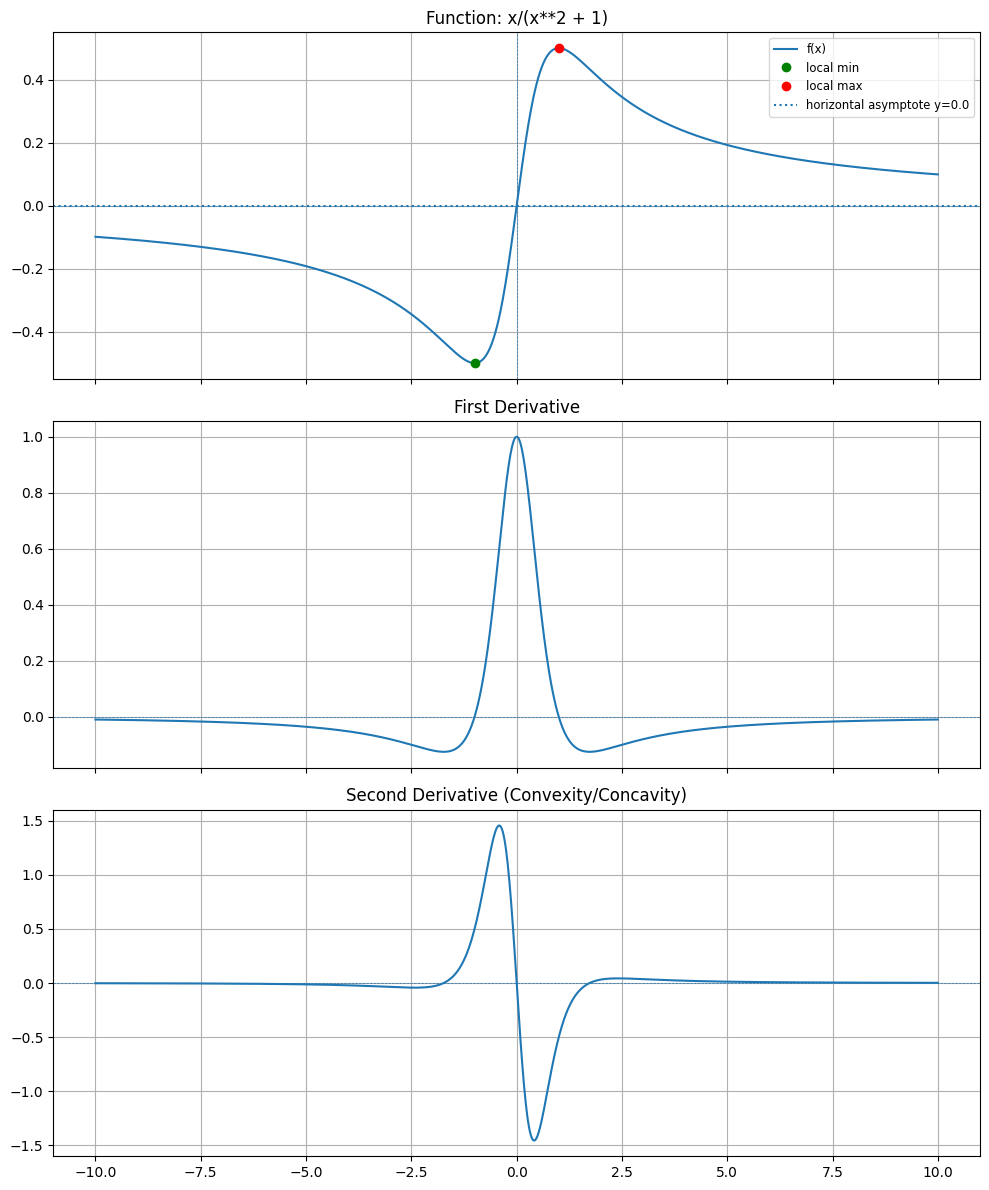

In [9]:
# Cell 9: Summary and plots
summary_lines = []
summary_lines.append(r"\text{Domain: } " + latex(domain))
if function_range is not None:
    summary_lines.append(r"\text{Range: } " + latex(function_range))
if 'increasing' in globals() and increasing is not None:
    summary_lines.append(r"\text{Increasing on: } " + latex(increasing))
if 'decreasing' in globals() and decreasing is not None:
    summary_lines.append(r"\text{Decreasing on: } " + latex(decreasing))
if 'convex_intervals' in globals() and convex_intervals is not None:
    summary_lines.append(r"\text{Convex on: } " + latex(convex_intervals))
if 'concave_intervals' in globals() and concave_intervals is not None:
    summary_lines.append(r"\text{Concave on: } " + latex(concave_intervals))
display(Math(r" \\\\ ".join(summary_lines)))

# Plot function, first and second derivatives, mark extrema and asymptotes
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
xs_plot = []
ys_plot = []
for interval in intervals:
    if isinstance(interval, sp.Interval):
        a = interval.start
        b = interval.end
        def to_float(u):
            if u in (sp.S.NegativeInfinity, sp.S.Infinity):
                return None
            return float(sp.N(u))
        left = to_float(a)
        right = to_float(b)
        if left is None and right is None:
            pts = np.linspace(-10, 10, 1000)
        elif left is None:
            pts = np.linspace(right - 10, right - 1e-3, 1000)
        elif right is None:
            pts = np.linspace(left + 1e-3, left + 10, 1000)
        else:
            eps = 1e-6
            low = left + (eps if interval.left_open else 0)
            high = right - (eps if interval.right_open else 0)
            pts = np.linspace(low, high, 1000)
        xs_plot.append(pts)
        f_num = sp.lambdify(x, f, 'numpy')
        with np.errstate(all='ignore'):
            ys_plot.append(f_num(pts))

# Top: function
for pts, vals in zip(xs_plot, ys_plot):
    axes[0].plot(pts, vals, label='f(x)')
axes[0].set_title(f'Function: {expr}')
axes[0].axhline(0, linewidth=0.5, linestyle='--')
axes[0].axvline(0, linewidth=0.5, linestyle='--')

# Mark local extrema
for cp, typ in local_extrema.items():
    try:
        cp_val = float(sp.N(cp))
        fcp = float(sp.N(f.subs(x, cp)))
        if 'minimum' in typ:
            axes[0].plot(cp_val, fcp, 'go', label='local min')
        elif 'maximum' in typ:
            axes[0].plot(cp_val, fcp, 'ro', label='local max')
        else:
            axes[0].plot(cp_val, fcp, 'ko', label='inconclusive')
    except Exception:
        pass

# Asymptotes
for ha in asymptotes.get('horizontal', []):
    if isinstance(ha, sp.Equality):
        y_val = float(sp.N(ha.rhs))
        axes[0].axhline(y_val, linestyle=':', label=f'horizontal asymptote y={y_val}')
for oa in asymptotes.get('oblique', []):
    m = sp.simplify(sp.diff(oa, x))
    b = sp.simplify(oa - m * x)
    try:
        m_f = float(sp.N(m))
        b_f = float(sp.N(b))
        xs = np.linspace(-10, 10, 400)
        axes[0].plot(xs, m_f * xs + b_f, '--', label=f'oblique asymptote {sp.simplify(oa)}')
    except Exception:
        pass

axes[0].legend(loc='best', fontsize='small')
axes[0].grid(True)

# First derivative
fprime_num = sp.lambdify(x, fprime, 'numpy')
for pts in xs_plot:
    with np.errstate(all='ignore'):
        axes[1].plot(pts, fprime_num(pts), label="f'(x)")
axes[1].set_title('First Derivative')
axes[1].axhline(0, linewidth=0.5, linestyle='--')
axes[1].grid(True)

# Second derivative
fsecond_num = sp.lambdify(x, fsecond, 'numpy')
for pts in xs_plot:
    with np.errstate(all='ignore'):
        axes[2].plot(pts, fsecond_num(pts), label="f''(x)")
axes[2].set_title('Second Derivative (Convexity/Concavity)')
axes[2].axhline(0, linewidth=0.5, linestyle='--')
axes[2].grid(True)

plt.tight_layout()
plt.show()
